Dataset columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']

Data filtered to 149171 records in 4 categories.

Unique Categories and Labels: {'Consumer Loan': 0, 'Debt collection': 1, 'Mortgage': 2}

Training Logistic Regression...
Logistic Regression Accuracy: 94.56%
Classification Report:
                 precision    recall  f1-score   support

  Consumer Loan       0.82      0.64      0.72      1895
Debt collection       0.95      0.97      0.96     17342
       Mortgage       0.95      0.96      0.96     10598

       accuracy                           0.95     29835
      macro avg       0.91      0.86      0.88     29835
   weighted avg       0.94      0.95      0.94     29835



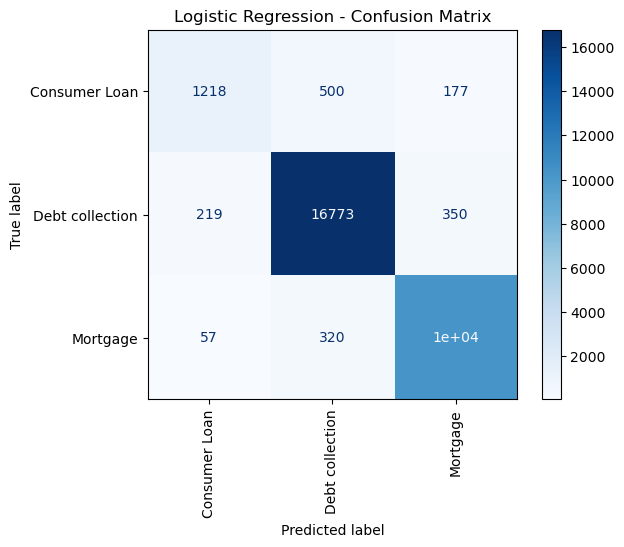


Training Naive Bayes...
Naive Bayes Accuracy: 92.85%
Classification Report:
                 precision    recall  f1-score   support

  Consumer Loan       0.85      0.43      0.57      1895
Debt collection       0.94      0.96      0.95     17342
       Mortgage       0.91      0.97      0.94     10598

       accuracy                           0.93     29835
      macro avg       0.90      0.79      0.82     29835
   weighted avg       0.93      0.93      0.92     29835



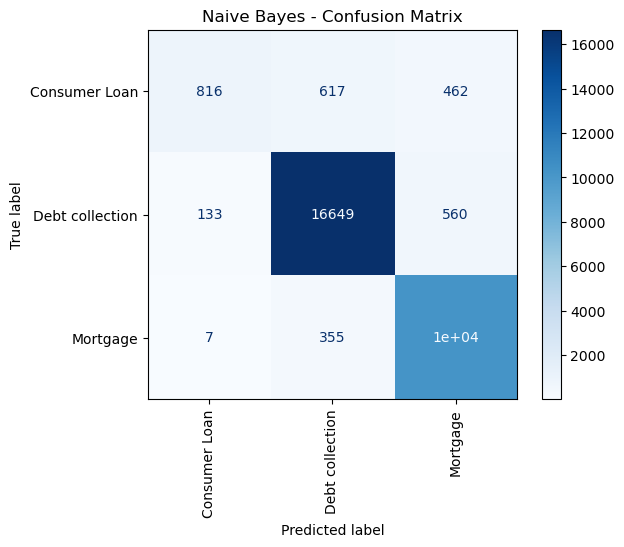


Training Linear SVM...
Linear SVM Accuracy: 94.50%
Classification Report:
                 precision    recall  f1-score   support

  Consumer Loan       0.81      0.65      0.72      1895
Debt collection       0.95      0.96      0.96     17342
       Mortgage       0.95      0.97      0.96     10598

       accuracy                           0.94     29835
      macro avg       0.90      0.86      0.88     29835
   weighted avg       0.94      0.94      0.94     29835



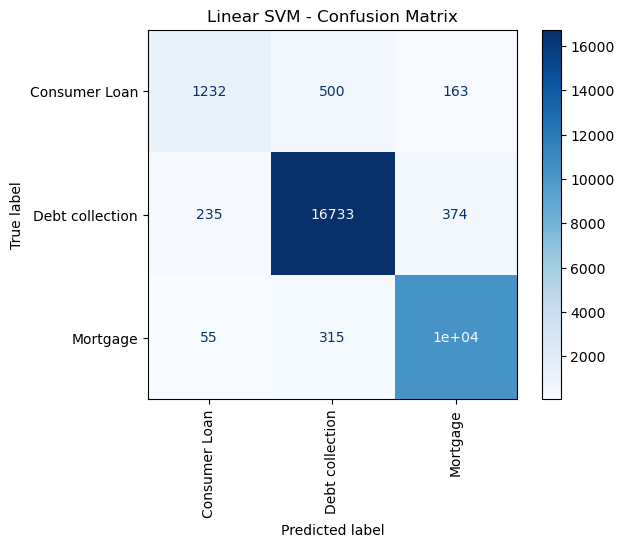

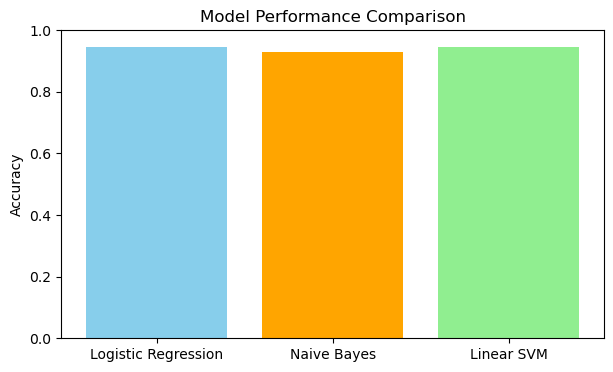


✅ Best Model: Logistic Regression
✅ Accuracy: 94.56%


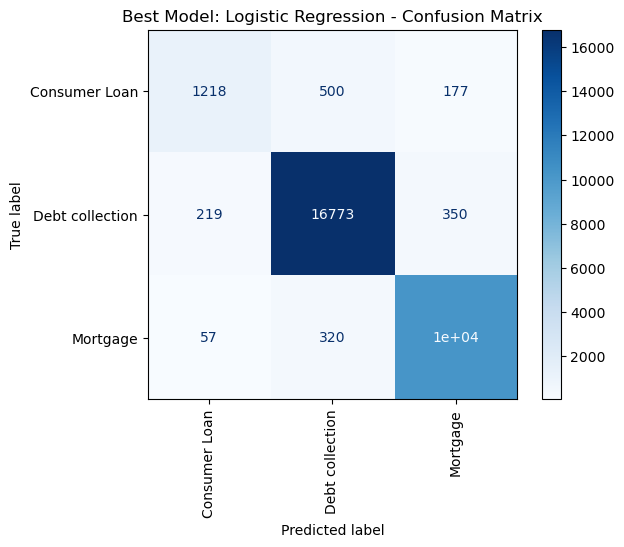


--- User Input Mode ---


Enter a consumer complaint description:  The bank closed my account without any reason



Predicted Product Category: Debt collection

--- Sample Predictions ---
Complaint: The bank closed my account without any reason.
Predicted Product: Debt collection

Complaint: Debt collectors are calling me repeatedly about a loan I don't owe.
Predicted Product: Debt collection

Complaint: My mortgage payment was not processed on time.
Predicted Product: Mortgage

Complaint: My credit report contains errors and false information.
Predicted Product: Debt collection



In [1]:
# =======================
# 1. Import Dependencies
# =======================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.feature_extraction import text

# =======================
# 2. Load Dataset
# =======================
path = "/kaggle/input/consumer-complaint-database/rows.csv"  # Change this if local
df = pd.read_csv(path, low_memory=False)

# Display columns
print("Dataset columns:", df.columns.tolist())

# Keep only relevant columns
df = df[['Product', 'Consumer complaint narrative']].dropna()

# =======================
# 3. Filter Required Categories
# =======================
target_categories = [
    'Credit reporting, repair, or other',
    'Debt collection',
    'Consumer Loan',
    'Mortgage'
]

df = df[df['Product'].isin(target_categories)]
print(f"\nData filtered to {len(df)} records in 4 categories.")

# =======================
# 4. Text Preprocessing (Offline Safe)
# =======================
stop_words = text.ENGLISH_STOP_WORDS

def clean_text(text_input):
    text_input = text_input.lower()
    text_input = re.sub(r'[^a-z\s]', '', text_input)
    text_input = ' '.join([word for word in text_input.split() if word not in stop_words])
    return text_input

df['cleaned_text'] = df['Consumer complaint narrative'].apply(clean_text)

# =======================
# 5. Encode Labels
# =======================
le = LabelEncoder()
df['label'] = le.fit_transform(df['Product'])
print("\nUnique Categories and Labels:", dict(zip(le.classes_, le.transform(le.classes_))))

# =======================
# 6. Train-Test Split
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# =======================
# 7. TF-IDF Vectorization
# =======================
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# =======================
# 8. Train and Evaluate Models
# =======================
models = {
    "Logistic Regression": LogisticRegression(max_iter=300),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC()
}

results = {}
model_objects = {}

for name, model in models.items():
    print(f"\n{'='*30}\nTraining {name}...\n{'='*30}")
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    model_objects[name] = model

    # Print metrics
    print(f"{name} Accuracy: {acc*100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix for each model
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(xticks_rotation=90, cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

# =======================
# 9. Compare Model Performance
# =======================
plt.figure(figsize=(7,4))
plt.bar(results.keys(), results.values(), color=['skyblue', 'orange', 'lightgreen'])
plt.title("Model Performance Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

# =======================
# 10. Identify Best Model
# =======================
best_model_name = max(results, key=results.get)
best_model = model_objects[best_model_name]

print(f"\n✅ Best Model: {best_model_name}")
print(f"✅ Accuracy: {results[best_model_name]*100:.2f}%")

# Confusion Matrix for Best Model
y_pred_best = best_model.predict(X_test_vec)
cm_best = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=le.classes_)
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title(f"Best Model: {best_model_name} - Confusion Matrix")
plt.show()

# =======================
# 11. User Input Prediction
# =======================
print("\n--- User Input Mode ---")
user_input = input("Enter a consumer complaint description: ")

user_cleaned = clean_text(user_input)
user_vec = vectorizer.transform([user_cleaned])
prediction = best_model.predict(user_vec)
predicted_category = le.inverse_transform(prediction)[0]

print(f"\nPredicted Product Category: {predicted_category}")

# =======================
# 12. Sample Predictions
# =======================
sample_texts = [
    "The bank closed my account without any reason.",
    "Debt collectors are calling me repeatedly about a loan I don't owe.",
    "My mortgage payment was not processed on time.",
    "My credit report contains errors and false information."
]

print("\n--- Sample Predictions ---")
for text_sample in sample_texts:
    cleaned = clean_text(text_sample)
    vec = vectorizer.transform([cleaned])
    pred = le.inverse_transform(best_model.predict(vec))[0]
    print(f"Complaint: {text_sample}\nPredicted Product: {pred}\n")
